In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import itertools
import os
import cv2

### Đọc dữ liệu

In [6]:
# đọc tên các lớp :  có 9 loại
# DIR = 'D:\study-hk2\ML\ML\classification_fish\data\Fish_Dataset' 
DIR = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
classes = [i for i in os.listdir(DIR) if '.' not in i]                     
classes

['Black Sea Sprat',
 'Gilt Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [7]:
data = []
path = "D:\\study\\machine_learning\\classification_fish\\data\\Fish_Dataset"
folders = os.listdir(path)
for folder in folders:
    folder_path = os.path.join(path, folder, folder)
    for i in range(1, 1001):
        img_path = os.path.join(folder_path, f"{str(i).zfill(5)}.png")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150, 150))
        data.append([img, folder])

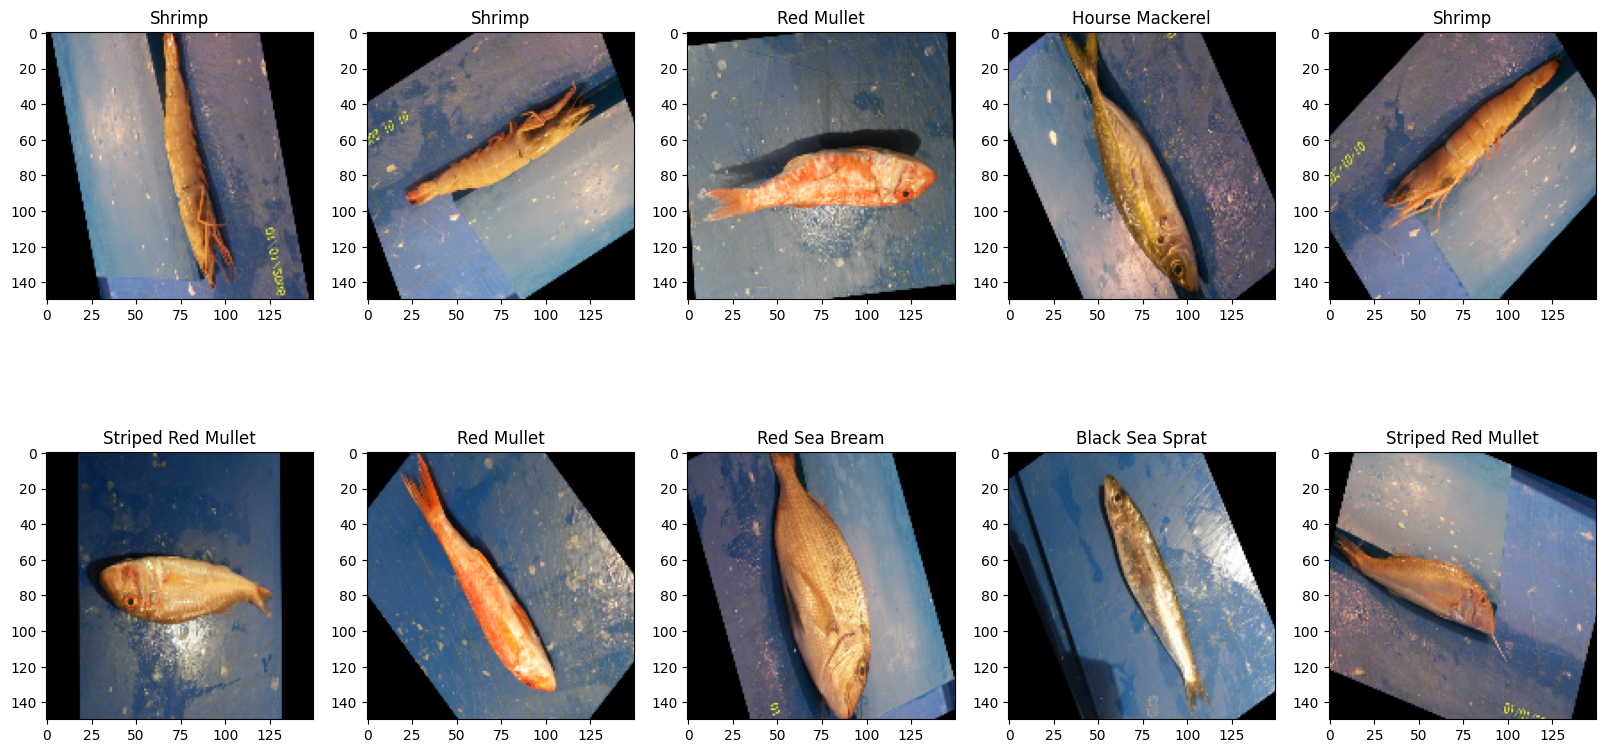

In [8]:
# in ra một vài ảnh và nhãn tương ứng
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(0, 9000)
    plt.imshow(data[j+i][0])
    plt.title(data[j+i][1])

In [9]:
# tạo image và label từ data
images = []
labels = []
for image, label in data:
    images.append(image)
    labels.append(label)

In [10]:
# chuấn hóa label
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)

# in ra label và tên tương ứng
for i in range(9):
    print(i, le.classes_[i])

0 Black Sea Sprat
1 Gilt Head Bream
2 Hourse Mackerel
3 Red Mullet
4 Red Sea Bream
5 Sea Bass
6 Shrimp
7 Striped Red Mullet
8 Trout


In [11]:
# chuẩn hóa label thành one-hot vector
from keras.utils import np_utils
labels = np_utils.to_categorical(labels, 9)
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [12]:
# reshape images
images = np.array(images)
images = images.reshape(images.shape[0], 150, 150, 3)
images.shape

(9000, 150, 150, 3)

In [13]:
# chuẩn hóa images
images = images.astype('float32') / 255.0

### Chia dữ liệu Train và Validation

In [14]:
# chia train, validation sao cho các lớp có số lượng ảnh tương đương nhau
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)

train_images.shape, val_images.shape, train_labels.shape, val_labels.shape

((8100, 150, 150, 3), (900, 150, 150, 3), (8100, 9), (900, 9))

In [15]:
# đếm số lượng ảnh của mỗi lớp trong tập train
unique, counts = np.unique(np.argmax(train_labels, axis=1), return_counts=True)
dict(zip(unique, counts))

{0: 900, 1: 900, 2: 900, 3: 900, 4: 900, 5: 900, 6: 900, 7: 900, 8: 900}

### Xây dựng model

##### Sử dụng thư viện

In [16]:
# xây dựng mô hình hồi quy Logistic với hàm softmax
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(solver = 'lbfgs', multi_class='multinomial')
logisticRegr.fit(train_images, np.argmax(train_labels, axis=1))

ValueError: Found array with dim 4. LogisticRegression expected <= 2.

In [ ]:
---

##### Xây dựng Logistic Regression

In [ ]:
def convert_labels(y, C):
    from scipy import sparse
    Y = sparse.coo_matrix((np.ones_like(y),
                           (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

def softmax(Z):
    e_Z = np.expt(Z)
    A = e_Z / e_Z.sum(axis=0)
    return A

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = e_Z / e_Z.sum(axis=0)
    return A

def predict(W, X):
    A = softmax_stable(np.dot(W.T, X))
    return np.argmax(A, axis=0)

In [ ]:
def _softmax_regression(X, Y, theta, lambda_= 0.5,iterations=10, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss

    losse = []
    _theta = theta
    d, N = X.shape

    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losse.append(log_loss(Y.T, Y_hat.T))
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat)/N}")

    return _theta, losse